# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Constants

In [2]:
# Data types
const_dtype = { 'ano': int, 'uf': str, 'genero': str, 'mes': str, 'numero': int }

In [3]:
const_dict_month = {
    'Janeiro': 1,   'Fevereiro': 2,   'Março': 3,       'Abril': 4,
    'Maio': 5,      'Junho': 6,       'Julho': 7,       'Agosto': 8,
    'Setembro': 9,  'Outubro': 10,    'Novembro': 11,   'Dezembro': 12
}

const_arr_months = [key for key, value in const_dict_month.items()]

# Functions

This section is intended to contain all the functions used along the code

## Loading data

Functions used to download the basic data

In [4]:
def list_csv_files(url):
    response = requests.get(url)

    if response.status_code == 200:
        content = response.json()
        csv_files = [file['download_url'] for file in content if file['name'].endswith('.csv')]
        return csv_files
    else:
        print(f'Error accessing URL.\nStatus code: {response.status_code}')

In [5]:
def get_dataframes(user, repo, folder, dtype=None):
    url = f'https://api.github.com/repos/{user}/{repo}/contents/{folder}'
    csv_files = list_csv_files(url)

    df_list = []

    for file_url in csv_files:
        df = pd.read_csv(file_url, dtype=dtype)
        df_list.append(df)

    df_list = pd.concat(df_list, ignore_index=True)

    return df_list

## Pre-processing

All functions of the data pre-processing stage

In [6]:
def eliminate_columns(df, columns=[]):
    # Drop columns
    df = df.drop(columns=columns)
    return df

In [7]:
def find_rows_with_null_values(df):
    # Indexes of rows with null values
    idxNullRows = pd.isnull(df).any().to_numpy().nonzero()

    return idxNullRows

## Regression model

Definition of the regression model

### Dataset preparer

In [8]:
def prepare_dataset(df, start_year):
    df = pd.get_dummies(df, columns=['genero'], drop_first=True)

    # Add number of month
    df['n_mes'] = df['mes'].map(const_dict_month)

    # Column to represent time since the start data
    df['tempo'] = (df['ano'] - start_year) * 12 + df['n_mes']

    return df

In [9]:
def define_dataset(df, resources_columns, target_column=False):
    # Define X using df and resource variables
    X = df[resources_columns]

    # Define Y using target variable
    y = df[target_column] if target_column else None

    return X, y

In [10]:
def split_dataset(X, y, test_size=0.3):
    # Split dataset with the selected test_size or 70/30 by default
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=13)

    return X_train, X_test, y_train, y_test

### Define model & predict

In [11]:
def define_model(X_train, y_train):
    # Create LinearRegression Model
    model = LinearRegression()

    # Compile model
    model.fit(X_train, y_train)

    return model

In [12]:
def predict(model, X):
    y_pred = model.predict(X)
    return y_pred

In [13]:
def summary_model(uf, X_train, X_test, y_train, y_test, y_pred):
    mae = round(mean_absolute_error(y_test, y_pred), 4)
    mse = round(mean_squared_error(y_test, y_pred), 4)

    print(f'========== Model {uf} ==========')
    print(f'\nData Split (proportion {test_size}):')
    print(f'\tX_train: {X_train.shape} | y_train: {y_train.shape}')
    print(f'\tX_test: {X_test.shape} | y_test: {y_test.shape}')
    print(f'\nModel metrics:')
    print(f'\tErro Médio Absoluto (MAE): {mae}')
    print('\tO MAE indica a média da diferença entre o valor real com o predito\n')
    print(f'\tErro Quadrático Médio (MSE): {mse}')
    print('\tO MSE indica a diferença real/previsto, porém acentuando diferenças maiores\n\n')

## Report utils

Complementary functions to show results of the model predict

In [14]:
def get_min_max_year(df):
    return df['ano'].min(), df['ano'].max()

In [15]:
def get_largests_ufs_by_year(df, year, n=3):
    # Filter data os previous year
    df_previous_year = df[df['ano'] == year]

    # Group targert column using column uf
    total_per_uf = df_previous_year.groupby('uf')['numero'].sum()

    # Sort results and get top N
    top_n_ufs = total_per_uf.nlargest(n)

    # Format ufs in a list
    top_n_ufs = list(top_n_ufs.to_dict().keys())

    return top_n_ufs

In [16]:
def format_predicted_df(uf, df):
    df['uf'] = uf
    df['genero'] = [ 'Masculino' if value == True else 'Feminino' for value in df['genero_Masculino'] ]
    df['numero'] = [ int(value) for value in df['numero'] ]

    return df

### Show results

In [17]:
def show_table(df, columns, titles, sort='numero', ascending=False):
    if sort=='numero':
        grouped_df = df.groupby(columns)['numero'].sum().sort_values(ascending=ascending)
        grouped_df.sort_values(ascending=ascending)
    else:
        df.sort_values(by=[sort], inplace=True, ascending=ascending)
        grouped_df = df.groupby(columns)['numero'].sum()

    table_data = grouped_df.reset_index().values.tolist()
    table_str = tabulate(table_data, headers=titles, tablefmt='grid')
    print(f'\n{table_str}')

In [18]:
def show_grouped_results(df):
    unique_ufs = df['uf'].unique()
    unique_years = df['uf'].unique()
    df['n_mes'] = df['mes'].map(const_dict_month)
    show_table(df, columns=['ano'], titles=['Ano', 'Número'], sort='ano', ascending=True)
    show_table(df, columns=['uf'], titles=['UF', 'Número'], sort='uf', ascending=True)
    show_table(df, columns=['genero'], titles=['Gênero', 'Número'])
    show_table(df, columns=['uf', 'genero'], titles=['UF', 'Gênero', 'Número'], sort='uf', ascending=True)
    show_table(df, columns=['n_mes', 'mes'], titles=['', 'Mês', 'Número'], sort='n_mes', ascending=True)

In [19]:
def results_per_month(df):
    df['n_mes'] = df['mes'].map(const_dict_month)
    unique_genders = df['genero'].unique()
    unique_months = df['mes'].unique()
    for gender in unique_genders:
        grouped_df = df[(df['genero'] == gender)].groupby('n_mes')
        ax = grouped_df['numero'].sum().plot(marker='o')
    ax.grid(True)
    ax.set_xticks(range(1, len(unique_months)+1))
    ax.set_xlim(1, len(unique_months))
    xticks = const_arr_months
    ax.set_xticklabels(xticks)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Mês', fontsize=12)
    ax.set_ylabel('Casamentos', fontsize=12)
    plt.legend(unique_genders)
    plt.title(f'Casamentos homoafetivos por mês')
    plt.show()

In [20]:
def results_per_year(df):
    unique_genders = df['genero'].unique()
    unique_years = df['genero'].unique()
    for gender in unique_genders:
        grouped_df = df[(df['genero'] == gender)].groupby('ano')
        ax = grouped_df['numero'].sum().plot(marker='o')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Ano', fontsize=12)
    ax.set_ylabel('Casamentos', fontsize=12)
    plt.legend(unique_genders)
    plt.title(f'Casamentos homoafetivos por ano')
    plt.show()

In [21]:
def results_per_uf_and_gender(df, top_3_ufs=[]):
    unique_ufs = top_3_ufs if top_3_ufs != [] else df['uf'].unique()
    unique_genders = df['genero'].unique()
    for uf in unique_ufs:
        for gender in unique_genders:
            grouped_df = df[(df['uf'] == uf) & (df['genero'] == gender)].groupby('ano')
            ax = grouped_df['numero'].sum().plot(marker='o')
        ax.grid(True)
        plt.legend(unique_genders)
        ax.set_xlabel('Ano', fontsize=12)
        ax.set_ylabel('Casamentos', fontsize=12)
        plt.title(f'Casamentos homoafetivos em {uf}')
        plt.show()

# Execution

This section contains all the executions and processes needed to consume and generate data

## Create and fit model

In [22]:
# GitHub repository with the data
user, repo, folder = 'GabrielNG13', 'ps-mediamonks-datascience', 'data/transient'

# Loading data
raw_df = get_dataframes(user, repo, folder, const_dtype)

In [23]:
dfs_per_uf = raw_df.groupby('uf')
models = {}

for uf, df in dfs_per_uf:

    # Drop uf column
    df = eliminate_columns(df, columns=['uf'])

    # No record has any null values
    # No action necessary
    rows = find_rows_with_null_values(df)

    # Set the start year
    start_year, _ = get_min_max_year(df)
    dataset = prepare_dataset(df, df['ano'].min())

    # Set categorical and target columns
    resources_columns = ['ano', 'tempo', 'n_mes'] + [ col for col in dataset.columns if 'genero' in col ]
    target_column = 'numero'

    X, y = define_dataset(dataset, resources_columns, target_column)

    # Proportion test/total
    test_size = 0
    if test_size > 0:
        X_train, X_test, y_train, y_test = split_dataset(X, y, test_size)
    else:
        X_train, X_test, y_train, y_test = X, None, y, None

    # Create model
    model = define_model(X_train, y_train)

    # Results
    if test_size > 0:
      y_pred = predict(model, X_test)
      summary_model(uf, X_train, X_test, y_train, y_test, y_pred)

    # Store trained model
    models[uf] = model

## Predict Data

In [24]:
# Set the start and previous year
start_year, previous_year = get_min_max_year(raw_df)

# Get top 3 ufs
top_3_ufs = get_largests_ufs_by_year(raw_df, previous_year, 3)

In [25]:
# Define years to predict data
years = [str(int(previous_year) + 1), str(int(previous_year) + 2)]

# Get genders and months list
ufs = list(raw_df['uf'].unique())
genders = list(raw_df['genero'].unique())
months = list(raw_df['mes'].unique())

# Generate DataFrame with combinations of year, uf, gender and month
combinations = list(product(years, ufs, genders, months))

# Create general DataFrame
columns = ['ano', 'uf', 'genero', 'mes']
df_predict = pd.DataFrame(combinations, columns=columns)
df_predict['ano'] = df_predict['ano'].astype(int)

In [26]:
dfs_to_predict = df_predict.loc[df_predict['uf'].isin(top_3_ufs)].groupby('uf')
predicts = {}

for uf, df in dfs_to_predict:

    # Drop uf column
    df = eliminate_columns(df, columns=['uf'])

    # No record has any null values
    # No action necessary
    rows = find_rows_with_null_values(df)

    dataset = prepare_dataset(df, start_year)

    # Set categorical columns
    resources_columns = ['ano', 'tempo', 'n_mes'] + [ col for col in dataset.columns if 'genero' in col ]

    X_predict, _ = define_dataset(dataset, resources_columns)
    dataset['numero'] = predict(models[uf], X_predict)

    predicts[uf] = dataset

In [27]:
predicted_df = pd.DataFrame()

for uf, df in predicts.items():

    # Format genero and numero columns
    df = format_predicted_df(uf, df)

    # Drop genero_Masculino and tempo columns
    df = eliminate_columns(df, columns=['genero_Masculino', 'tempo', 'n_mes'])

    # Add the dataframe per uf to principal dataframe
    predicted_df = pd.concat([predicted_df, df], ignore_index=True)

In [28]:
# Join predicted data with historic data
general_df = pd.DataFrame()
general_df = pd.concat([raw_df, predicted_df], ignore_index=True)

# Show report

The purpose of this section is specifically to explore and visualize historical and predicted data

## Historic analysys

raw_df is the Dataframe with all historic data

In [29]:
print('Casamentos homoafetivos nos últimos anos: ')
show_grouped_results(raw_df)

Casamentos homoafetivos nos últimos anos: 

+-------+----------+
|   Ano |   Número |
+=======+==========+
|  2015 |     5614 |
+-------+----------+
|  2016 |     5354 |
+-------+----------+
|  2017 |     5887 |
+-------+----------+
|  2018 |     9520 |
+-------+----------+
|  2019 |     9056 |
+-------+----------+
|  2020 |     6433 |
+-------+----------+
|  2021 |     9202 |
+-------+----------+

+---------------------+----------+
| UF                  |   Número |
+=====================+==========+
| Acre                |       81 |
+---------------------+----------+
| Alagoas             |      512 |
+---------------------+----------+
| Amapá               |       81 |
+---------------------+----------+
| Amazonas            |      454 |
+---------------------+----------+
| Bahia               |     1531 |
+---------------------+----------+
| Ceará               |     2166 |
+---------------------+----------+
| Distrito Federal    |     1378 |
+---------------------+----------+
| E

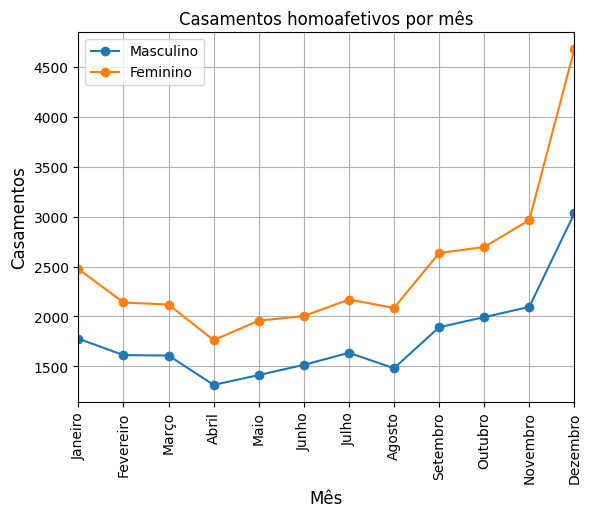

In [30]:
results_per_month(raw_df)

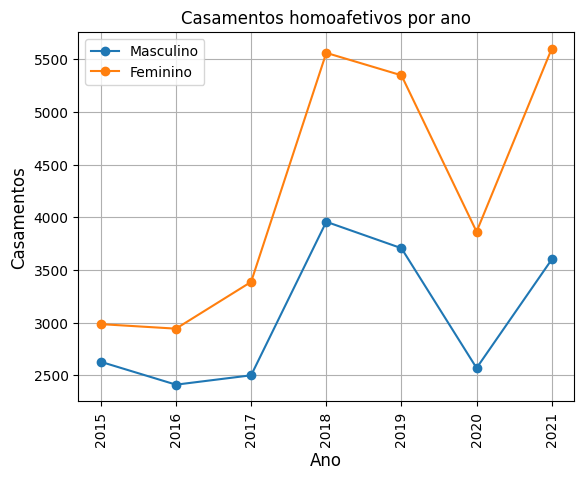

In [31]:
results_per_year(raw_df)

## Predictive analysis

predicted_df is the Dataframe with all historic and predicted data

In [32]:
print('Previsão de casamentos homoafetivos nos próximos 2 anos: ')
show_grouped_results(predicted_df)

Previsão de casamentos homoafetivos nos próximos 2 anos: 

+-------+----------+
|   Ano |   Número |
+=======+==========+
|  2022 |     5340 |
+-------+----------+
|  2023 |     5652 |
+-------+----------+

+----------------+----------+
| UF             |   Número |
+================+==========+
| Minas Gerais   |     1753 |
+----------------+----------+
| Rio de Janeiro |     1473 |
+----------------+----------+
| São Paulo      |     7766 |
+----------------+----------+

+-----------+----------+
| Gênero    |   Número |
+===========+==========+
| Feminino  |     6239 |
+-----------+----------+
| Masculino |     4753 |
+-----------+----------+

+----------------+-----------+----------+
| UF             | Gênero    |   Número |
+================+===========+==========+
| Minas Gerais   | Feminino  |      958 |
+----------------+-----------+----------+
| Minas Gerais   | Masculino |      795 |
+----------------+-----------+----------+
| Rio de Janeiro | Feminino  |      843 |
+---------

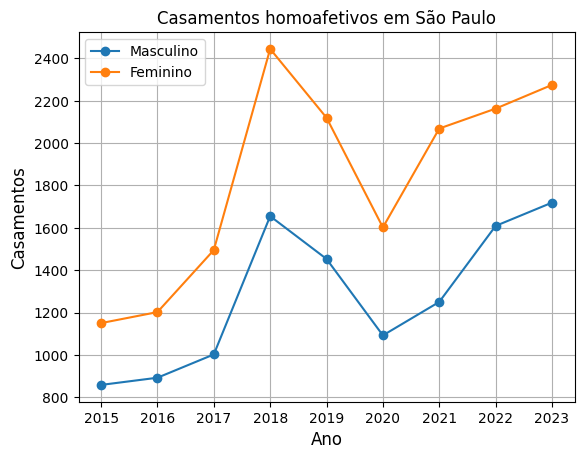

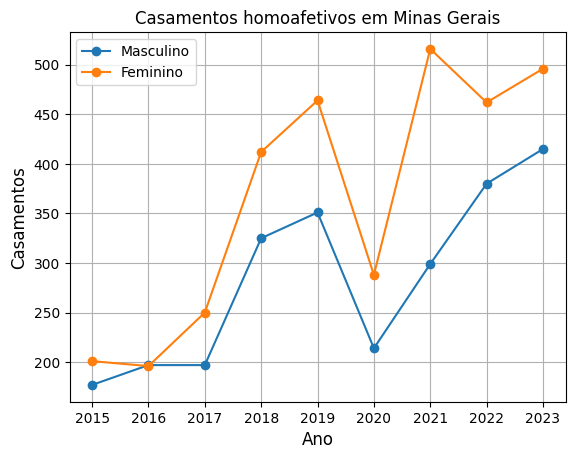

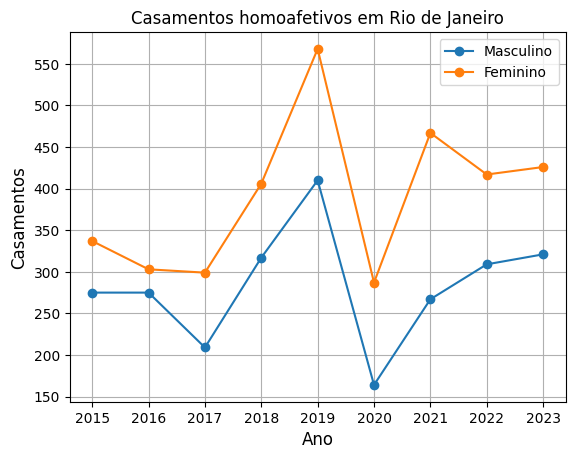

In [33]:
results_per_uf_and_gender(general_df, top_3_ufs)